In [102]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import uuid
import os
import time
import cv2
import json

In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
images = tf.data.Dataset.list_files("/home/swaraj/sj_code/cv_models/data/images/*.jpg", shuffle=False)


In [ ]:
print(list(images.as_numpy_iterator().next()))


In [3]:
def load_image(x):
    byte_img=tf.io.read_file(x)
    img=tf.io.decode_jpeg(byte_img)
    return img



In [ ]:
images=images.map(load_image)

In [4]:
images.as_numpy_iterator().next()

NameError: name 'images' is not defined

In [ ]:
image_generator=images.batch(4).as_numpy_iterator()
plot_images=image_generator.next()
fig,ax=plt.subplots(ncols=4,figsize=(20,20))
for idx,image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

In [ ]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data',folder,'images')):
        filename=file.split('.')[0]+'.json'
        existing_filepath=os.path.join('data','labels',filename)
        if os.path.exists(existing_filepath):
            new_filepath=os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath,new_filepath)

In [ ]:
!pip install albumentations

In [ ]:
img=cv2.imread(os.path.join('data','train','images','67bf96b6-6fe0-11f0-9ce7-d3baada8ec11.jpg'))

In [ ]:
img.shape

In [ ]:
import albumentations as alb

In [ ]:
augmentor = alb.Compose([
    alb.RandomCrop(width=450, height=450, p=1.0), 
    alb.HorizontalFlip(p=0.5),
    alb.RandomBrightnessContrast(p=0.2),
    alb.RandomGamma(p=0.2),
    alb.RGBShift(p=0.2),
    alb.VerticalFlip(p=0.5)], 
    bbox_params=alb.BboxParams(format='albumentations', 
    label_fields=['class_labels'] ))


In [ ]:
with open(os.path.join('data','train','labels','67bf96b6-6fe0-11f0-9ce7-d3baada8ec11.json'),'r') as f:
    label=json.load(f)

label

In [ ]:
t1=tf.reshape(tf.constant(label['shapes'][0]['points']),[-1])
coords=tf.math.divide(t1,tf.constant([640,480,640,480],dtype=tf.float32))
print(coords)

In [ ]:
augmented=augmentor(image=img,bboxes=[coords],class_labels=['face'])
print(augmented)

In [ ]:
augmented['bboxes']

In [ ]:
cv2.rectangle(augmented['image'],
              tuple(np.multiply(augmented['bboxes'][0][:2],[450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:],[450,450]).astype(int)),
              (255,0,0),2)
plt.imshow(augmented['image'])

In [ ]:
list(np.array(label['shapes'][0]['points']).flatten().astype('float64'))

In [ ]:
for partition in ['train', 'test', 'val']:
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))
        coords = [0] * 4
        label_path = os.path.join('data', partition, 'labels', f"{image.split('.')[0]}.json")

        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)
            coords = np.array(label['shapes'][0]['points']).flatten()
            coords = coords / np.array([640, 480, 640, 480])

        try:
            for x in range(120):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

                cv2.imwrite(
                    os.path.join('aug_data', partition, 'images', f"{image.split('.')[0]}.{x}.jpg"),
                    augmented['image']
                )

                annotation = {'image': image}
                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0:
                        annotation['bbox'] = [0] * 4
                        annotation['class'] = 0
                    else:
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else:
                    annotation['bbox'] = [0] * 4
                    annotation['class'] = 0  

                with open(
                    os.path.join('aug_data', partition, 'labels', f"{image.split('.')[0]}.{x}.json"), 'w'
                ) as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)


In [ ]:
with open (os.path.join('aug_data','train','labels','3d9dd422-6fe0-11f0-9ce7-d3baada8ec11.7.json'),'r') as f:
    print(json.load(f))

In [5]:
train_images=tf.data.Dataset.list_files('aug_data/train/images/*.jpg',shuffle=False).map(load_image).map(lambda x: tf.image.resize(x,(120,120))).map(lambda x:x/255)
test_images=tf.data.Dataset.list_files('aug_data/test/images/*.jpg',shuffle=False).map(load_image).map(lambda x: tf.image.resize(x,(120,120))).map(lambda x:x/255)
val_images=tf.data.Dataset.list_files('aug_data/val/images/*.jpg',shuffle=False).map(load_image).map(lambda x: tf.image.resize(x,(120,120))).map(lambda x:x/255)

I0000 00:00:1754308657.625714    6361 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2614 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


Cause: could not parse the source code of <function <lambda> at 0x71ebccd556c0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x / 255

Match 1:
lambda x: tf.image.resize(x, (120, 120))

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x71ebccd556c0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x / 255

Match 1:
lambda x: tf.image.resize(x, (120, 120))

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x71ec7c217b50>: found multi

In [6]:
train_images.as_numpy_iterator().next()

array([[[0.1038603 , 0.14307599, 0.04895834],
        [0.071875  , 0.11893383, 0.03363971],
        [0.08707108, 0.1341299 , 0.05569853],
        ...,
        [0.1882353 , 0.19607843, 0.05098039],
        [0.13756128, 0.14791666, 0.01930147],
        [0.12530637, 0.13431373, 0.02150735]],

       [[0.11372549, 0.15147059, 0.06176471],
        [0.0971201 , 0.13241422, 0.05006127],
        [0.10055147, 0.13584559, 0.05349265],
        ...,
        [0.23186274, 0.23970588, 0.09362745],
        [0.1867647 , 0.19117647, 0.05637255],
        [0.14491421, 0.14883578, 0.02708333]],

       [[0.1254902 , 0.16078432, 0.07843138],
        [0.09797794, 0.13278186, 0.05042892],
        [0.10539216, 0.1367647 , 0.05441177],
        ...,
        [0.26715687, 0.275     , 0.12205882],
        [0.2283701 , 0.23621324, 0.09013481],
        [0.17677696, 0.18069853, 0.05765931]],

       ...,

       [[0.50661767, 0.5668505 , 0.49693626],
        [0.57218134, 0.6466912 , 0.5682598 ],
        [0.5211397 , 0

In [7]:
def load_labels(label_path):
    with open(label_path.numpy(),'r',encoding='utf-8') as f:
        label=json.load(f)

    return [label['class']],label['bbox']

In [8]:
train_labels = tf.data.Dataset.list_files('aug_data/train/labels/*.json', shuffle=False) \
    .map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

test_labels = tf.data.Dataset.list_files('aug_data/test/labels/*.json', shuffle=False) \
    .map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

val_labels = tf.data.Dataset.list_files('aug_data/val/labels/*.json', shuffle=False) \
    .map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))


In [9]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.4885, 0.    , 1.    , 0.785 ], dtype=float16))

In [ ]:
for i in [train_images,train_labels,test_images,test_labels,val_images,val_labels]:
    print(len(i))

In [10]:
train=tf.data.Dataset.zip((train_images,train_labels)).shuffle(5000).batch(8).prefetch(4)
test=tf.data.Dataset.zip((test_images,test_labels)).shuffle(5000).batch(8).prefetch(4)
val=tf.data.Dataset.zip((val_images,val_labels)).shuffle(5000).batch(8).prefetch(4)

In [ ]:
data_sample=train.as_numpy_iterator().next()
img,lab=data_sample
print("img=",type(img))
print("lab=",type(lab))
img,lab=data_sample
print("lab=",lab)
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx in range(4):
    sample_imgs = data_sample[0][idx].copy()  
    sample_coords = data_sample[1][1][idx]

    cv2.rectangle(sample_imgs,
                  tuple(np.multiply(sample_coords[:2], [120, 120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120, 120]).astype(int)),
                  (255, 0, 0), 2)

    ax[idx].imshow(sample_imgs)


In [11]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Conv2D,Dense,Flatten,GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [12]:
def build_model():
    input_layer=Input(shape=(120,120,3))
    vgg=VGG16(include_top=False)(input_layer)
    
    f1=GlobalMaxPooling2D()(vgg)
    class1=Dense(2048,activation='relu')(f1)
    class2=Dense(1,activation='sigmoid')(class1)
    
    f2=GlobalMaxPooling2D()(vgg)
    regress1=Dense(2048,activation='relu')(f2)
    regress2=Dense(4,activation='sigmoid')(regress1)

    facetracker=Model(inputs=input_layer,outputs=[class2,regress2])
    return facetracker
    

In [13]:
model1 = build_model()
model1.summary()  # Shows all layers, shapes, params


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 120, 120,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 3, 3, 512) │ 14,714,688 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 2048)      │  1,050,624 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2048)      │  1,050,624 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      2,049 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 4)         │      8,196 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,826,181 (64.19 MB)

 Trainable params: 16,826,181 (64.19 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
for i, layer in enumerate(model1.layers):
    print(f"{i:02d} | {layer.name:30s} | Trainable: {layer.trainable}")


00 | input_layer                    | Trainable: True
01 | vgg16                          | Trainable: True
02 | global_max_pooling2d           | Trainable: True
03 | dense                          | Trainable: True
04 | dense_2                        | Trainable: True
05 | dense_1                        | Trainable: True
06 | dense_3                        | Trainable: True


In [15]:
len(train)

645

In [16]:
sample=train.as_numpy_iterator().next()
print("sample=",sample)
print("-----------------------------------------------")
x,y=sample
print("x=",x)
print("-----------------------------------------------")
print("y=",y)

2025-08-04 17:28:25.698659: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:21: Filling up shuffle buffer (this may take a while): 3817 of 5000


sample= (array([[[[0.22254902, 0.18333334, 0.2211397 ],
         [0.20606618, 0.16734068, 0.203125  ],
         [0.2163603 , 0.14430147, 0.21305147],
         ...,
         [0.08903186, 0.05275735, 0.06991421],
         [0.11158089, 0.05018383, 0.07205883],
         [0.11599265, 0.05814951, 0.05716912]],

        [[0.2439951 , 0.20183824, 0.20876226],
         [0.2278799 , 0.19552696, 0.15287991],
         [0.24313726, 0.18578431, 0.15631127],
         ...,
         [0.06721814, 0.05196078, 0.040625  ],
         [0.09957108, 0.03933823, 0.05042892],
         [0.10294118, 0.02843137, 0.04509804]],

        [[0.27322304, 0.19889706, 0.20049019],
         [0.2348652 , 0.18045343, 0.17322303],
         [0.25085783, 0.18088235, 0.16458334],
         ...,
         [0.07064951, 0.06917892, 0.03057598],
         [0.0814951 , 0.04754902, 0.04957108],
         [0.0846201 , 0.03235294, 0.06758578]],

        ...,

        [[0.3723652 , 0.2963848 , 0.32432598],
         [0.35049018, 0.28382352, 0.

2025-08-04 17:28:29.311099: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


In [17]:
batches_per_epoch=len(train)
lr_decay=(1/0.75 -1)/batches_per_epoch
opt=tf.keras.optimizers.Adam(learning_rate=0.0001,decay=lr_decay)

/home/swaraj/tf_env/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [18]:
def localisation_loss(y_true,y_hat):
    delta_coord=tf.reduce_sum(tf.square(y_true[:,:2]-y_hat[:,:2]))

    h_true=y_true[:,3]-y_true[:,1]
    w_true=y_true[:,2]-y_true[:,0]
    h_pred=y_hat[:,3]-y_hat[:,1]
    w_pred=y_hat[:,2]-y_hat[:,0]

    delta_size=tf.reduce_sum(tf.square(w_true-w_pred)+tf.square(h_true-h_pred))
    return delta_coord+delta_size
    

In [19]:
classloss=tf.losses.BinaryCrossentropy()
regressloss=localisation_loss

In [22]:
y_pred=model1.predict(x)
classes,coords=y

I0000 00:00:1754308751.492850    6462 service.cc:152] XLA service 0x71eb04004350 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754308751.492863    6462 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2025-08-04 17:29:11.943661: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1754308752.486907    6462 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-08-04 17:29:15.675610: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.39 = (f32[8,64,120,120]{3,2,1,0}, u8[0]{0}) custom-call(f32[8,3,120,120]{3,2,1,0} %bitcast.570, f32[64,3,3,3]{3,2,1,0} %bitcast.577, f32[64]{0} %bitcast.579), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__c

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


I0000 00:00:1754308759.626885    6462 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [23]:
print(y)
print("----------------------------------")
print(classes)
print("------------------------------------")
print(coords)

(array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]], dtype=uint8), array([[0.5337  , 0.313   , 1.      , 1.      ],
       [0.2976  , 0.01291 , 0.862   , 0.859   ],
       [0.11145 , 0.003845, 0.5728  , 0.739   ],
       [0.4802  , 0.1625  , 1.      , 0.876   ],
       [0.      , 0.      , 0.3828  , 0.814   ],
       [0.      , 0.3599  , 0.2498  , 1.      ],
       [0.      , 0.1412  , 0.4172  , 0.9746  ],
       [0.2015  , 0.10864 , 0.7915  , 0.8735  ]], dtype=float16))
----------------------------------
[[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]]
------------------------------------
[[0.5337   0.313    1.       1.      ]
 [0.2976   0.01291  0.862    0.859   ]
 [0.11145  0.003845 0.5728   0.739   ]
 [0.4802   0.1625   1.       0.876   ]
 [0.       0.       0.3828   0.814   ]
 [0.       0.3599   0.2498   1.      ]
 [0.       0.1412   0.4172   0.9746  ]
 [0.2015   0.10864  0.7915   0.8735  ]]


In [25]:
regloss=localisation_loss(y[1],coords)
print(regloss)

tf.Tensor(0.0, shape=(), dtype=float16)


In [26]:
clloss=classloss(y[0],classes)

In [27]:
print(clloss)

tf.Tensor(1.192093e-07, shape=(), dtype=float32)


In [28]:
base_model=tf.keras.applications.VGG16()
for layer in base_model.layers:
    print(layer,layer.trainable)

base_model.layers[3].trainable=False
print("----------------------")
for layer in base_model.layers:
    print(layer,layer.trainable)


<InputLayer name=input_layer_2, built=True> True
<Conv2D name=block1_conv1, built=True> True
<Conv2D name=block1_conv2, built=True> True
<MaxPooling2D name=block1_pool, built=True> True
<Conv2D name=block2_conv1, built=True> True
<Conv2D name=block2_conv2, built=True> True
<MaxPooling2D name=block2_pool, built=True> True
<Conv2D name=block3_conv1, built=True> True
<Conv2D name=block3_conv2, built=True> True
<Conv2D name=block3_conv3, built=True> True
<MaxPooling2D name=block3_pool, built=True> True
<Conv2D name=block4_conv1, built=True> True
<Conv2D name=block4_conv2, built=True> True
<Conv2D name=block4_conv3, built=True> True
<MaxPooling2D name=block4_pool, built=True> True
<Conv2D name=block5_conv1, built=True> True
<Conv2D name=block5_conv2, built=True> True
<Conv2D name=block5_conv3, built=True> True
<MaxPooling2D name=block5_pool, built=True> True
<Flatten name=flatten, built=True> True
<Dense name=fc1, built=True> True
<Dense name=fc2, built=True> True
<Dense name=predictions, b

In [29]:
class FaceTracker(Model):
    def __init__(self,eyetracker,**kwargs):
        super().__init__(**kwargs)
        self.model=eyetracker

    def compile(self,opt,classloss,localisationloss,**kwargs):
        super().compile(**kwargs)
        self.closs=classloss
        self.lloss=localisationloss
        self.opt=opt

    def train_step(self,batch,**kwargs):
        X,y=batch
        y_class,y_bbox= y
        y_class=tf.reshape(y_class, (-1, 1))
        y_bbox=tf.reshape(y_bbox, (-1, 4))
        y_class = tf.cast(y_class, tf.int32)
        y_bbox = tf.cast(y_bbox, tf.float32) 

        with tf.GradientTape() as tape:
            classes,coords=self.model(X,training=True)
            
            
            batch_classloss=self.closs(y_class,classes)
            batch_localisationloss=self.lloss(y_bbox, coords)
            total_loss=batch_localisationloss+0.5*batch_classloss
            grad=tape.gradient(total_loss,self.model.trainable_variables)
        opt.apply_gradients(zip(grad,self.model.trainable_variables))
        return {"total_loss":total_loss,"class_loss":batch_classloss,"regress_loss":batch_localisationloss}

    def test_step(self, batch, **kwargs):
        X, y = batch
        y_class, y_bbox = y  
        y_class=tf.reshape(y_class, (-1, 1))
        y_bbox=tf.reshape(y_bbox, (-1, 4))
        y_class = tf.cast(y_class, tf.int32)
        y_bbox = tf.cast(y_bbox, tf.float32)
    
        classes, coords = self.model(X, training=False)
        batch_classloss = self.closs(y_class, classes)
        batch_localisationloss = self.lloss(y_bbox, coords)
        total_loss = batch_localisationloss + 0.5 * batch_classloss
        return {
            "total_loss": total_loss,
            "class_loss": batch_classloss,
            "regress_loss": batch_localisationloss
        }

    def call(self,X,**kwargs):
        return self.model(X,**kwargs)


In [30]:
model=FaceTracker(model1)
9575557555 anurag un

In [31]:
model.compile(opt,classloss,regressloss)

In [32]:
logdir='logs'
tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [33]:
hist=model.fit(train,epochs=40,validation_data=val,callbacks=[tensorboard_callback])

Epoch 1/40


2025-08-04 17:30:02.212911: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.39 = (f32[8,64,120,120]{3,2,1,0}, u8[0]{0}) custom-call(f32[8,3,120,120]{3,2,1,0} %bitcast.6267, f32[64,3,3,3]{3,2,1,0} %bitcast.6274, f32[64]{0} %bitcast.7485), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/vgg16_1/block1_conv1_1/StatefulPartitionedCall/convolution" source_file="/home/swaraj/tf_env/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-08-04 17:30:02.268171: I external/local_xla/xla/service/gpu/autotuning/conv_a

645/645 ━━━━━━━━━━━━━━━━━━━━ 110s 149ms/step - class_loss: 3.6180e-04 - regress_loss: 0.0486 - total_loss: 0.0488 - val_class_loss: 6.7779e-04 - val_regress_loss: 0.4899 - val_total_loss: 0.4903
Epoch 2/40
645/645 ━━━━━━━━━━━━━━━━━━━━ 97s 145ms/step - class_loss: 3.0277e-05 - regress_loss: 0.0309 - total_loss: 0.0309 - val_class_loss: 0.0016 - val_regress_loss: 0.1904 - val_total_loss: 0.1912
Epoch 3/40
645/645 ━━━━━━━━━━━━━━━━━━━━ 97s 146ms/step - class_loss: 9.5083e-05 - regress_loss: 0.0203 - total_loss: 0.0204 - val_class_loss: 0.1100 - val_regress_loss: 0.5241 - val_total_loss: 0.5791
Epoch 4/40
645/645 ━━━━━━━━━━━━━━━━━━━━ 98s 147ms/step - class_loss: 2.8742e-05 - regress_loss: 0.0204 - total_loss: 0.0204 - val_class_loss: 0.0056 - val_regress_loss: 0.2870 - val_total_loss: 0.2898
Epoch 5/40
645/645 ━━━━━━━━━━━━━━━━━━━━ 99s 148ms/step - class_loss: 6.8796e-05 - regress_loss: 0.0137 - total_loss: 0.0138 - val_class_loss: 4.8499e-04 - val_regress_loss: 0.4181 - val_total_loss: 0.41

2025-08-04 18:22:40.392510: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:21: Filling up shuffle buffer (this may take a while): 564 of 5000
2025-08-04 18:22:50.393310: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:21: Filling up shuffle buffer (this may take a while): 1180 of 5000
2025-08-04 18:23:00.397468: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:21: Filling up shuffle buffer (this may take a while): 1799 of 5000
2025-08-04 18:23:20.399379: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:21: Filling up shuffle buffer (this may take a while): 2997 of 5000
2025-08-04 18:23:32.410544: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


645/645 ━━━━━━━━━━━━━━━━━━━━ 866s 1s/step - class_loss: 6.9157e-08 - regress_loss: 0.0017 - total_loss: 0.0017 - val_class_loss: 0.5052 - val_regress_loss: 1.1582 - val_total_loss: 1.4109
Epoch 33/40
645/645 ━━━━━━━━━━━━━━━━━━━━ 95s 143ms/step - class_loss: 8.7826e-07 - regress_loss: 0.0026 - total_loss: 0.0026 - val_class_loss: 0.0856 - val_regress_loss: 0.6406 - val_total_loss: 0.6834
Epoch 34/40
645/645 ━━━━━━━━━━━━━━━━━━━━ 97s 146ms/step - class_loss: 7.4126e-09 - regress_loss: 0.0026 - total_loss: 0.0026 - val_class_loss: 8.5738e-04 - val_regress_loss: 0.4885 - val_total_loss: 0.4889
Epoch 35/40
645/645 ━━━━━━━━━━━━━━━━━━━━ 101s 152ms/step - class_loss: 6.3881e-09 - regress_loss: 0.0029 - total_loss: 0.0029 - val_class_loss: 8.3856e-06 - val_regress_loss: 0.6332 - val_total_loss: 0.6332
Epoch 36/40
645/645 ━━━━━━━━━━━━━━━━━━━━ 103s 154ms/step - class_loss: 0.5150 - regress_loss: 1.4755 - total_loss: 1.7330 - val_class_loss: 6.8056e-04 - val_regress_loss: 0.3468 - val_total_loss: 0

In [62]:
h1=hist.history
print(h1)


{'class_loss': [0.00036180252209305763, 3.027726779691875e-05, 9.508339280728251e-05, 2.87422735709697e-05, 6.879563443362713e-05, 3.182741056662053e-05, 0.00017309421673417091, 0.0003041877062059939, 7.641216143383645e-06, 5.488646274898201e-05, 1.799862275220221e-06, 9.481298093305668e-07, 0.0001458309416193515, 6.118288638390368e-06, 5.732160934712738e-05, 3.4827211493393406e-05, 3.9800988815841265e-06, 0.00016591098392382264, 2.4647126338095404e-05, 4.006470044259913e-05, 1.4187757187755778e-05, 3.406946461836924e-06, 2.374755058554001e-05, 4.982428436051123e-06, 7.409949489556311e-07, 1.679649471952871e-06, 4.992067488274188e-07, 7.254663501043979e-07, 5.1079314999924463e-08, 1.9166382116964087e-06, 3.494682943028238e-08, 6.915727368550506e-08, 8.782555482866883e-07, 7.4126234039795236e-09, 6.388118034550416e-09, 0.5150086879730225, 7.643159847248171e-07, 0.0006074992124922574, 1.372554834233597e-06, 6.6052689362550154e-06], 'regress_loss': [0.04860682785511017, 0.0308658033609390

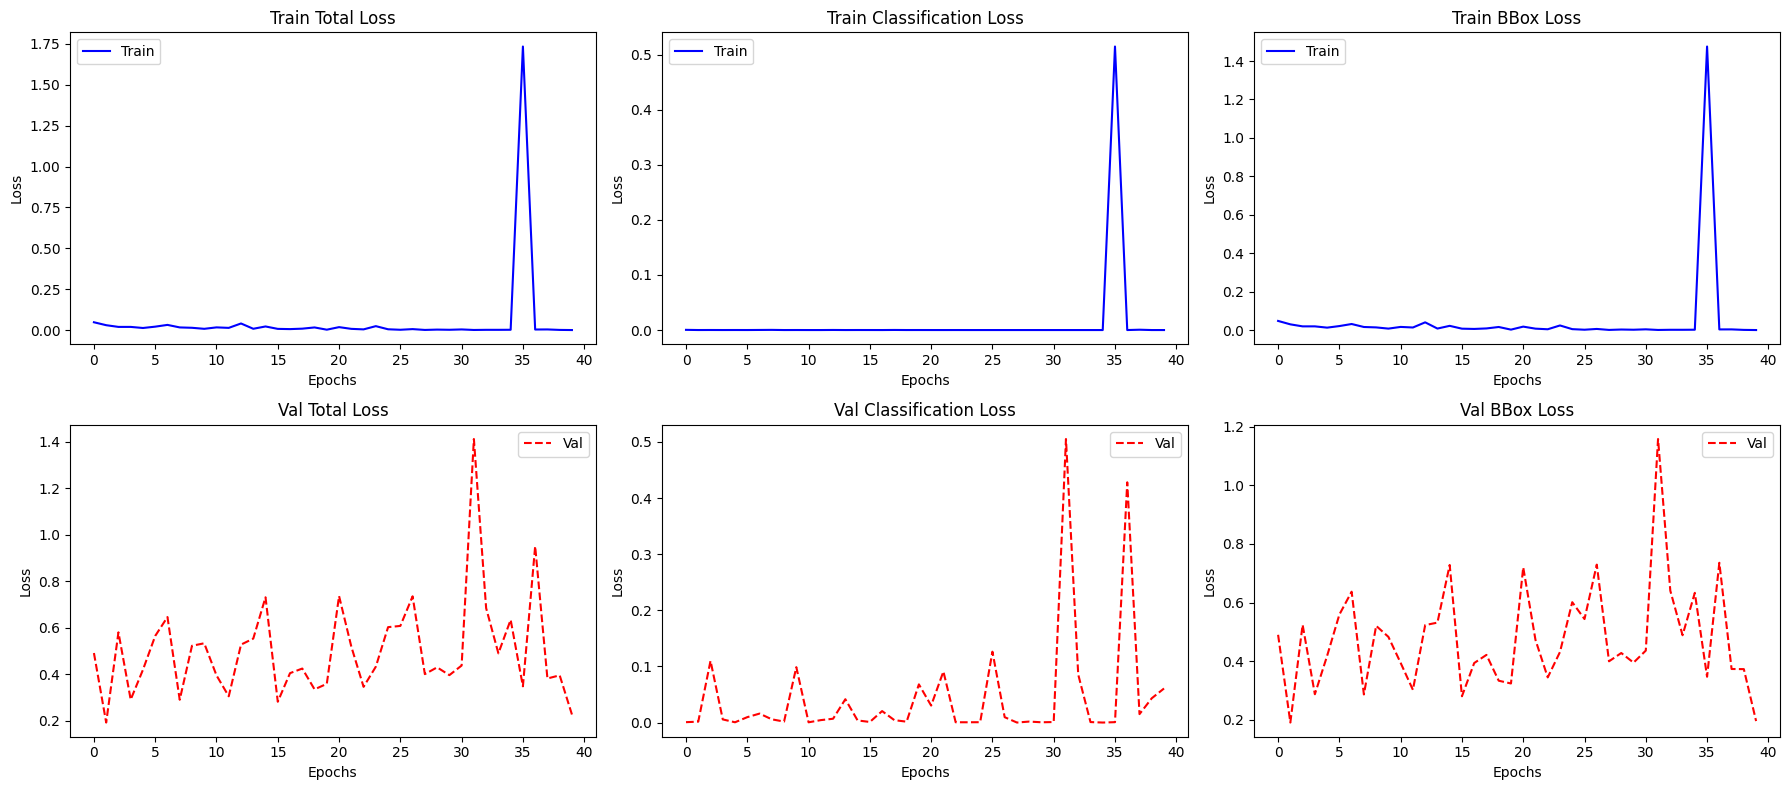

In [64]:
fig, axes = plt.subplots(2, 3, figsize=(18, 8))

axes[0, 0].plot(h1['total_loss'], 'b-')
axes[0, 0].set_title("Train Total Loss")
axes[0, 0].set_xlabel("Epochs")
axes[0, 0].set_ylabel("Loss")
axes[0, 0].legend(['Train'])

axes[0, 1].plot(h1['class_loss'], 'b-')
axes[0, 1].set_title("Train Classification Loss")
axes[0, 1].set_xlabel("Epochs")
axes[0, 1].set_ylabel("Loss")
axes[0, 1].legend(['Train'])

axes[0, 2].plot(h1['regress_loss'], 'b-')
axes[0, 2].set_title("Train BBox Loss")
axes[0, 2].set_xlabel("Epochs")
axes[0, 2].set_ylabel("Loss")
axes[0, 2].legend(['Train'])

axes[1, 0].plot(h1['val_total_loss'], 'r--')
axes[1, 0].set_title("Val Total Loss")
axes[1, 0].set_xlabel("Epochs")
axes[1, 0].set_ylabel("Loss")
axes[1, 0].legend(['Val'])

axes[1, 1].plot(h1['val_class_loss'], 'r--')
axes[1, 1].set_title("Val Classification Loss")
axes[1, 1].set_xlabel("Epochs")
axes[1, 1].set_ylabel("Loss")
axes[1, 1].legend(['Val'])

axes[1, 2].plot(h1['val_regress_loss'], 'r--')
axes[1, 2].set_title("Val BBox Loss")
axes[1, 2].set_xlabel("Epochs")
axes[1, 2].set_ylabel("Loss")
axes[1, 2].legend(['Val'])

plt.tight_layout()
plt.show()


In [77]:
test_data = test.as_numpy_iterator()


In [97]:
test_sample = test_data.next()


In [108]:
print(test_sample[0].shape)

(8, 120, 120, 3)


In [98]:
yhat = model1.predict(test_sample[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


In [99]:
print(y_hat)

[array([[1.       ],
       [1.       ],
       [0.9999994],
       [1.       ],
       [0.9999999],
       [1.       ],
       [0.9999995],
       [0.9999999]], dtype=float32), array([[0.52963024, 0.29546213, 0.9947839 , 0.99119407],
       [0.30896872, 0.01348353, 0.86276   , 0.86293334],
       [0.10981353, 0.00361739, 0.5762965 , 0.73180616],
       [0.48182833, 0.14969377, 0.9991916 , 0.86918277],
       [0.00197899, 0.00246726, 0.396089  , 0.8145911 ],
       [0.00316388, 0.35864234, 0.2754525 , 0.99694246],
       [0.00175924, 0.13922544, 0.40751752, 0.97307014],
       [0.20395693, 0.10369711, 0.78862476, 0.8824546 ]], dtype=float32)]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


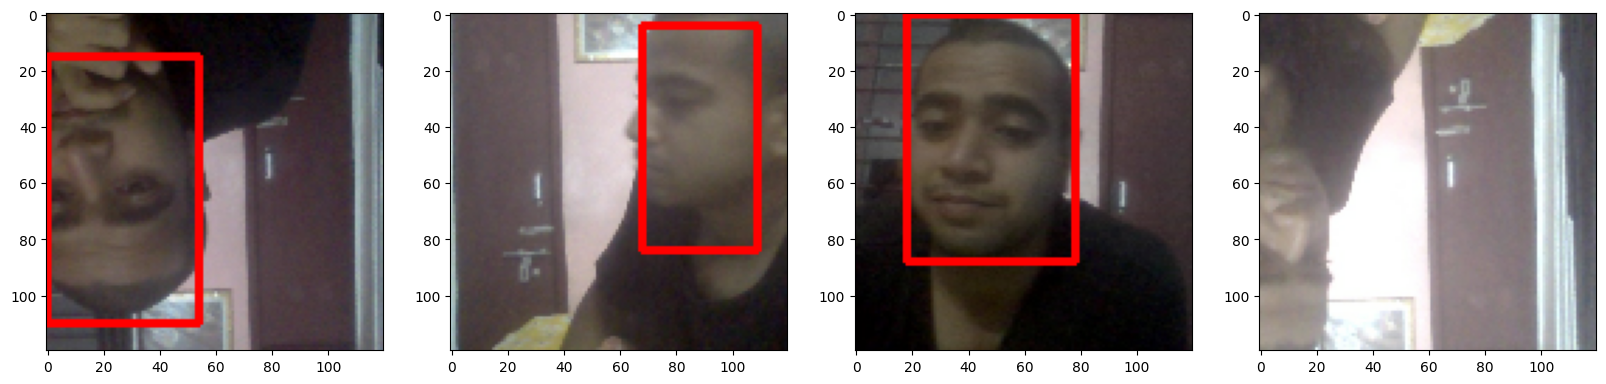

In [100]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx].copy()
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0),2)
    
    ax[idx].imshow(sample_image)

In [105]:
from tensorflow.keras.models import load_model

In [106]:
model1.save('FaceTracker.h5')

In [107]:
f1=load_model('FaceTracker.h5')